## Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/2024_top3_eda.csv")

df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

df

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_time,end_time,duration
0,classic_bike,2024-03-05 16:22:21.209,2024-03-05 16:27:31.958,W 21 St & 6 Ave,8 Ave & W 27 St,16.372500,16.458611,5.179150
1,classic_bike,2024-03-09 15:20:28.187,2024-03-09 15:35:11.183,W 21 St & 6 Ave,8 Ave & W 27 St,15.341111,15.586389,14.716600
2,electric_bike,2024-03-14 13:18:08.205,2024-03-14 13:24:04.862,W 21 St & 6 Ave,8 Ave & W 27 St,13.302222,13.401111,5.944283
3,electric_bike,2024-03-05 12:28:59.121,2024-03-05 12:33:58.145,W 21 St & 6 Ave,8 Ave & W 27 St,12.483056,12.566111,4.983733
4,electric_bike,2024-03-14 06:29:53.388,2024-03-14 06:32:09.311,W 21 St & 6 Ave,E 17 St & Broadway,6.498056,6.535833,2.265383
...,...,...,...,...,...,...,...,...
871379,classic_bike,2024-03-13 14:53:51.084,2024-03-13 15:00:58.722,W 21 St & 6 Ave,8 Ave & W 27 St,14.897500,15.016111,7.127300
871380,classic_bike,2024-03-10 14:46:09.276,2024-03-10 14:47:51.774,8 Ave & W 31 St,8 Ave & W 27 St,14.769167,14.797500,1.708300
871381,electric_bike,2024-03-01 14:57:35.469,2024-03-01 15:07:35.691,8 Ave & W 31 St,E 17 St & Broadway,14.959722,15.126389,10.003700
871382,electric_bike,2024-03-06 08:16:14.629,2024-03-06 08:36:22.402,8 Ave & W 31 St,E 72 St & York Ave,8.270556,8.606111,20.129550


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871384 entries, 0 to 871383
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   rideable_type       871384 non-null  object        
 1   started_at          871384 non-null  datetime64[ns]
 2   ended_at            871384 non-null  datetime64[ns]
 3   start_station_name  871384 non-null  object        
 4   end_station_name    871384 non-null  object        
 5   start_time          871384 non-null  float64       
 6   end_time            871384 non-null  float64       
 7   duration            871384 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 53.2+ MB


In [3]:
top3_stations = df.groupby('start_station_name').size().reset_index(name='count').sort_values(by='count', ascending=False)['start_station_name'].head(3).tolist()

In [4]:
# Outflow (-1) / Inflow (+1)
outflow = df[df['start_station_name'].isin(top3_stations)].copy()
outflow = outflow[['started_at', 'start_station_name', 'rideable_type']]
outflow.columns = ['time', 'station', 'rideable_type']
outflow['flow'] = -1

inflow = df[df['end_station_name'].isin(top3_stations)].copy()
inflow = inflow[['ended_at', 'end_station_name', 'rideable_type']]
inflow.columns = ['time', 'station', 'rideable_type']
inflow['flow'] = 1

combined = pd.concat([outflow, inflow])

# Resampling (15 mins)
net_flow_df = combined.groupby([
    pd.Grouper(key='time', freq='15min'),
    'station',
    'rideable_type'
])['flow'].sum().unstack(['station', 'rideable_type'], fill_value=0)

# Reindexing to fill every 15 min
start_date = net_flow_df.index.min().floor('D')
end_date = net_flow_df.index.max().ceil('D')

full_time_idx = pd.date_range(start=start_date, end=end_date, freq='15min', inclusive='left') 
net_flow_df = net_flow_df.reindex(full_time_idx, fill_value=0)


# Initial stock: Restore at every 00:00
initial_stock = 10
daily_cumsum = net_flow_df.groupby(pd.Grouper(freq='D')).cumsum()

stock_df = initial_stock + daily_cumsum

stock_df.head()

station             University Pl & E 14 St W 21 St & 6 Ave 8 Ave & W 31 St  \
rideable_type                 electric_bike    classic_bike    classic_bike   
2023-12-31 00:00:00                      10              10              10   
2023-12-31 00:15:00                      10              10              10   
2023-12-31 00:30:00                      10              10              10   
2023-12-31 00:45:00                      10              10              10   
2023-12-31 01:00:00                      10              10              10   

station                           W 21 St & 6 Ave University Pl & E 14 St  
rideable_type       electric_bike   electric_bike            classic_bike  
2023-12-31 00:00:00            10              10                      10  
2023-12-31 00:15:00            10              10                      10  
2023-12-31 00:30:00            10              10                      10  
2023-12-31 00:45:00            10              10                      10  
2023-12-31 01:00:00            10              10                      10

In [5]:
stock_df.shape, 365*24*4

((35232, 6), 35040)

In [6]:
stock_df['8 Ave & W 31 St']['classic_bike'][96:]

2024-01-01 00:00:00    10
2024-01-01 00:15:00    11
2024-01-01 00:30:00    11
2024-01-01 00:45:00    10
2024-01-01 01:00:00    10
                       ..
2024-12-31 22:45:00    18
2024-12-31 23:00:00    18
2024-12-31 23:15:00    17
2024-12-31 23:30:00    17
2024-12-31 23:45:00    17
Freq: 15min, Name: classic_bike, Length: 35136, dtype: int64

In [7]:
# How many days in 2024?
35136/24/4

366.0

In [8]:
stock_df = stock_df.iloc[96:]
stock_df

station             University Pl & E 14 St W 21 St & 6 Ave 8 Ave & W 31 St  \
rideable_type                 electric_bike    classic_bike    classic_bike   
2024-01-01 00:00:00                      10              10              10   
2024-01-01 00:15:00                       9              10              11   
2024-01-01 00:30:00                      10               9              11   
2024-01-01 00:45:00                      10               9              10   
2024-01-01 01:00:00                       9               9              10   
...                                     ...             ...             ...   
2024-12-31 22:45:00                      12               9              18   
2024-12-31 23:00:00                      14               9              18   
2024-12-31 23:15:00                      14               9              17   
2024-12-31 23:30:00                      13               9              17   
2024-12-31 23:45:00                      14               9              17   

station                           W 21 St & 6 Ave University Pl & E 14 St  
rideable_type       electric_bike   electric_bike            classic_bike  
2024-01-01 00:00:00            10              10                      10  
2024-01-01 00:15:00             9              12                      10  
2024-01-01 00:30:00             8              12                      10  
2024-01-01 00:45:00             7              14                      10  
2024-01-01 01:00:00             7              15                      10  
...                           ...             ...                     ...  
2024-12-31 22:45:00            20              21                      19  
2024-12-31 23:00:00            19              21                      19  
2024-12-31 23:15:00            19              20                      18  
2024-12-31 23:30:00            19              22                      18  
2024-12-31 23:45:00            20              23                      18  

[35136 rows x 6 columns]

In [9]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35136 entries, 2024-01-01 00:00:00 to 2024-12-31 23:45:00
Freq: 15min
Data columns (total 6 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   (University Pl & E 14 St, electric_bike)  35136 non-null  int64
 1   (W 21 St & 6 Ave, classic_bike)           35136 non-null  int64
 2   (8 Ave & W 31 St, classic_bike)           35136 non-null  int64
 3   (8 Ave & W 31 St, electric_bike)          35136 non-null  int64
 4   (W 21 St & 6 Ave, electric_bike)          35136 non-null  int64
 5   (University Pl & E 14 St, classic_bike)   35136 non-null  int64
dtypes: int64(6)
memory usage: 1.9 MB


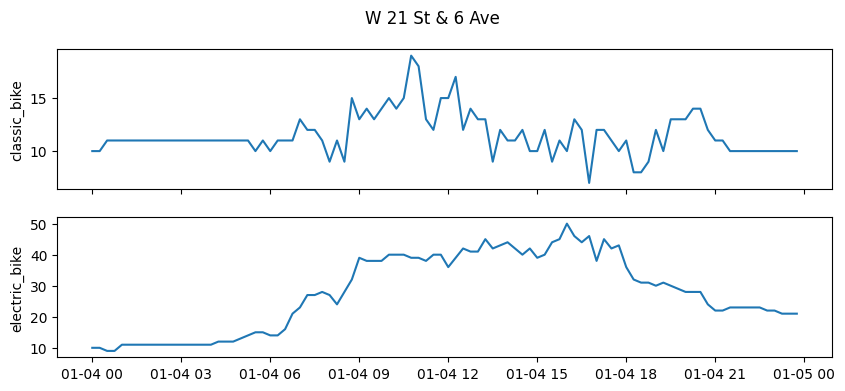

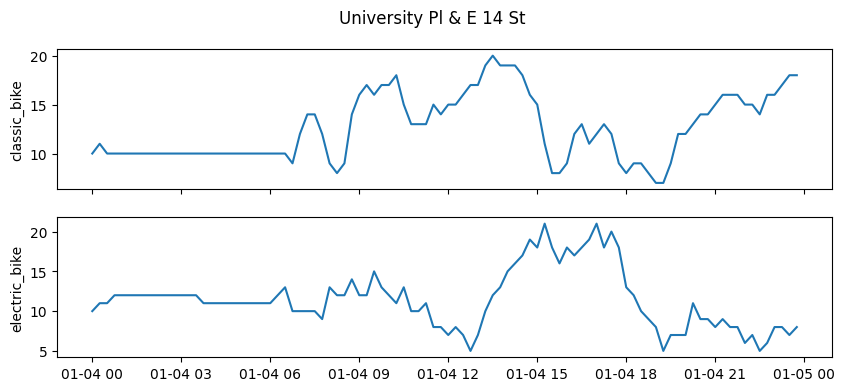

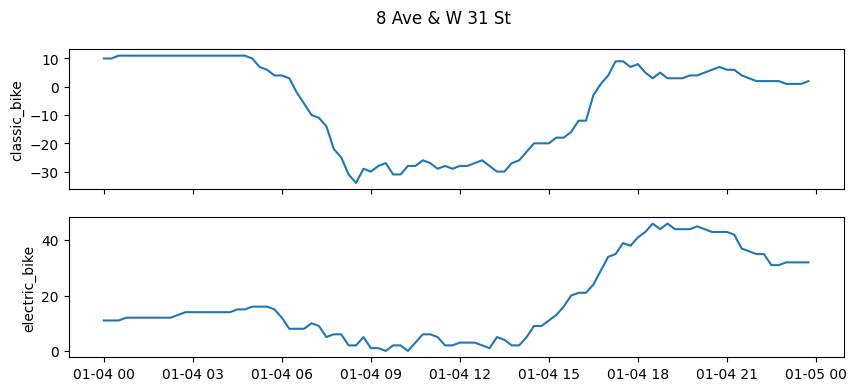

In [11]:
def figure_daily(date, station):

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 4))
    
    fig.suptitle(f"{station}")

    sns.lineplot(stock_df.loc[date,(station,'classic_bike')], ax=ax[0])
    ax[0].set_ylabel("classic_bike")
    ax[0].set_xticklabels([])
    ax[0].set_xlabel("")
    # ax[0].xticks(rotation=45, ha='right')


    sns.lineplot(stock_df.loc[date,(station,'electric_bike')], ax=ax[1])
    ax[1].set_ylabel("electric_bike")
    # ax[1].set_xticklabels(rotation=45, ha='right')

    plt.show()

for station in top3_stations:
    figure_daily('2024-01-04', station)


In [34]:
stock_df.to_csv("../data/2024_top3_timeseries.csv", index=True)

Let us change the multi-index dataframe to long dataframe for efficient feature engineering

In [12]:
long_df = stock_df.stack(level=[0, 1], future_stack=True).reset_index()
long_df.columns = ['time', 'station', 'rideable_type', 'stock']

long_df

,time,station,rideable_type,stock
0,2024-01-01 00:00:00,University Pl & E 14 St,electric_bike,10
1,2024-01-01 00:00:00,W 21 St & 6 Ave,classic_bike,10
2,2024-01-01 00:00:00,8 Ave & W 31 St,classic_bike,10
3,2024-01-01 00:00:00,8 Ave & W 31 St,electric_bike,10
4,2024-01-01 00:00:00,W 21 St & 6 Ave,electric_bike,10
...,...,...,...,...
210811,2024-12-31 23:45:00,W 21 St & 6 Ave,classic_bike,9
210812,2024-12-31 23:45:00,8 Ave & W 31 St,classic_bike,17
210813,2024-12-31 23:45:00,8 Ave & W 31 St,electric_bike,20
210814,2024-12-31 23:45:00,W 21 St & 6 Ave,electric_bike,23


In [13]:
long_df['hour']=long_df['time'].dt.hour + long_df['time'].dt.minute/60
long_df['dayofweek']=long_df['time'].dt.dayofweek

morning_rush = (long_df['hour'] >= 8) & (long_df['hour'] <= 10)
evening_rush = (long_df['hour'] >= 17) & (long_df['hour'] <= 19)

long_df['is_rush_hour'] = (morning_rush | evening_rush).astype(int)

grouper = long_df.groupby(['station', 'rideable_type'])['stock']

long_df['lag_15m_stock'] = grouper.shift(1)
long_df['lag_30m_stock'] = grouper.shift(2)
long_df['lag_45m_stock'] = grouper.shift(3)
long_df['lag_60m_stock'] = grouper.shift(4)
long_df['target_next_stock'] = grouper.shift(-1)

start_date = pd.to_datetime('2024-01-01')
end_date = pd.to_datetime('2025-01-01')

start_ts = start_date.to_numpy().astype(np.int64)
end_ts = end_date.to_numpy().astype(np.int64)

long_df['date'] = long_df['time'].dt.normalize()


long_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210816 entries, 0 to 210815
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   time               210816 non-null  datetime64[ns]
 1   station            210816 non-null  object        
 2   rideable_type      210816 non-null  object        
 3   stock              210816 non-null  int64         
 4   hour               210816 non-null  float64       
 5   dayofweek          210816 non-null  int32         
 6   is_rush_hour       210816 non-null  int64         
 7   lag_15m_stock      210810 non-null  float64       
 8   lag_30m_stock      210804 non-null  float64       
 9   lag_45m_stock      210798 non-null  float64       
 10  lag_60m_stock      210792 non-null  float64       
 11  target_next_stock  210810 non-null  float64       
 12  date               210816 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(6), int32(1), 

In [14]:
long_df['hour']=long_df['time'].dt.hour + long_df['time'].dt.minute/60
long_df['dayofweek']=long_df['time'].dt.dayofweek

morning_rush = (long_df['hour'] >= 8) & (long_df['hour'] <= 10)
evening_rush = (long_df['hour'] >= 17) & (long_df['hour'] <= 19)

long_df['is_rush_hour'] = (morning_rush | evening_rush).astype(int)

grouper = long_df.groupby(['station', 'rideable_type'])['stock']

long_df['lag_15m_stock'] = grouper.shift(1)
long_df['lag_30m_stock'] = grouper.shift(2)
long_df['lag_45m_stock'] = grouper.shift(3)
long_df['lag_60m_stock'] = grouper.shift(4)
long_df['target_next_stock'] = grouper.shift(-1)

start_date = pd.to_datetime('2024-01-01')
end_date = pd.to_datetime('2025-01-01')

start_ts = start_date.to_numpy().astype(np.int64)
end_ts = end_date.to_numpy().astype(np.int64)

long_df['date'] = long_df['time'].dt.normalize().to_numpy().astype(np.int64)

long_df['date'] = (long_df['date'] - start_ts) / (end_ts - start_ts)

final_df = long_df.dropna().copy()


final_df

,time,station,rideable_type,stock,hour,dayofweek,is_rush_hour,lag_15m_stock,lag_30m_stock,lag_45m_stock,lag_60m_stock,target_next_stock,date
24,2024-01-01 01:00:00,University Pl & E 14 St,electric_bike,9,1.0,0,0,10.0,10.0,9.0,10.0,11.0,0.000000
25,2024-01-01 01:00:00,W 21 St & 6 Ave,classic_bike,9,1.0,0,0,9.0,9.0,10.0,10.0,9.0,0.000000
26,2024-01-01 01:00:00,8 Ave & W 31 St,classic_bike,10,1.0,0,0,10.0,11.0,11.0,10.0,9.0,0.000000
27,2024-01-01 01:00:00,8 Ave & W 31 St,electric_bike,7,1.0,0,0,7.0,8.0,9.0,10.0,5.0,0.000000
28,2024-01-01 01:00:00,W 21 St & 6 Ave,electric_bike,15,1.0,0,0,14.0,12.0,12.0,10.0,15.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210805,2024-12-31 23:30:00,W 21 St & 6 Ave,classic_bike,9,23.5,1,0,9.0,9.0,9.0,9.0,9.0,0.997268
210806,2024-12-31 23:30:00,8 Ave & W 31 St,classic_bike,17,23.5,1,0,17.0,18.0,18.0,18.0,17.0,0.997268
210807,2024-12-31 23:30:00,8 Ave & W 31 St,electric_bike,19,23.5,1,0,19.0,19.0,20.0,20.0,20.0,0.997268
210808,2024-12-31 23:30:00,W 21 St & 6 Ave,electric_bike,22,23.5,1,0,20.0,21.0,21.0,21.0,23.0,0.997268


In [15]:
final_df.iloc[95*6]

time                     2024-01-02 00:45:00
station              University Pl & E 14 St
rideable_type                  electric_bike
stock                                      9
hour                                    0.75
dayofweek                                  1
is_rush_hour                               0
lag_15m_stock                            9.0
lag_30m_stock                            9.0
lag_45m_stock                            9.0
lag_60m_stock                           30.0
target_next_stock                        9.0
date                                0.002732
Name: 594, dtype: object

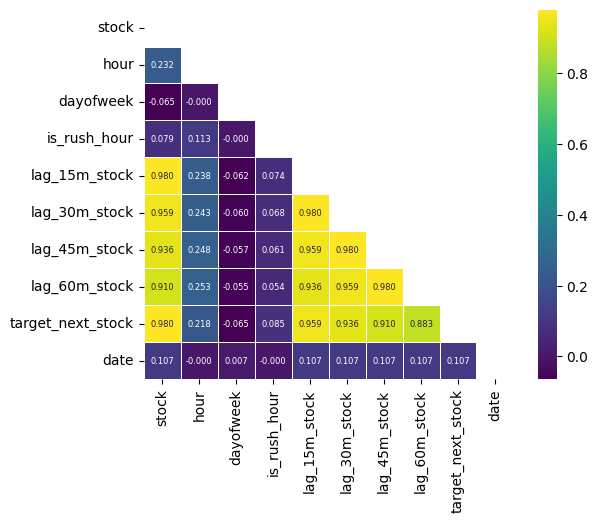

In [16]:
numerical_columns = final_df.select_dtypes(include=['number']).columns

corr = final_df[numerical_columns].corr()

mask = np.triu(np.ones_like(corr, dtype=bool) )

sns.heatmap(corr, mask=mask, annot=True, fmt=".3f", cmap='viridis', linewidths=0.5, square=True, annot_kws={"size": 6})
plt.show()

In [19]:
# drop `time` because it is included in other information
final_df = final_df.drop(columns=['time'])

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210786 entries, 24 to 210809
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   station            210786 non-null  object 
 1   rideable_type      210786 non-null  object 
 2   stock              210786 non-null  int64  
 3   hour               210786 non-null  float64
 4   dayofweek          210786 non-null  int32  
 5   is_rush_hour       210786 non-null  int64  
 6   lag_15m_stock      210786 non-null  float64
 7   lag_30m_stock      210786 non-null  float64
 8   lag_45m_stock      210786 non-null  float64
 9   lag_60m_stock      210786 non-null  float64
 10  target_next_stock  210786 non-null  float64
 11  date               210786 non-null  float64
dtypes: float64(7), int32(1), int64(2), object(2)
memory usage: 20.1+ MB


In [20]:
final_df.to_csv("../data/2024_top3_fe.csv", index=False)

# Modeling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("citi-bike")

df_ts = pd.read_csv("../data/2024_top3_timeseries.csv", index_col=0, header=[0, 1], parse_dates=True)

df = pd.read_csv("../data/2024_top3_fe.csv")

df['station'] = df['station'].astype('category')
df['rideable_type'] = df['rideable_type'].astype('category')

top3_stations = ['W 21 St & 6 Ave', 'University Pl & E 14 St', '8 Ave & W 31 St']

2025/12/21 22:32:05 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/21 22:32:05 INFO mlflow.store.db.utils: Updating database tables
2025/12/21 22:32:05 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/21 22:32:05 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/21 22:32:05 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/21 22:32:05 INFO alembic.runtime.migration: Will assume non-transactional DDL.


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210786 entries, 0 to 210785
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   station            210786 non-null  category
 1   rideable_type      210786 non-null  category
 2   stock              210786 non-null  int64   
 3   hour               210786 non-null  float64 
 4   dayofweek          210786 non-null  int64   
 5   is_rush_hour       210786 non-null  int64   
 6   lag_15m_stock      210786 non-null  float64 
 7   lag_30m_stock      210786 non-null  float64 
 8   lag_45m_stock      210786 non-null  float64 
 9   lag_60m_stock      210786 non-null  float64 
 10  target_next_stock  210786 non-null  float64 
 11  date               210786 non-null  float64 
dtypes: category(2), float64(7), int64(3)
memory usage: 16.5 MB


In [6]:
import torch
import random
import os

# Random seed setting (Reproducibility)
def seed_everything(seed: int = 42):
    # 1. Python seed
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed) # Hash based calculation (Ex: Dictionary) 
    
    # 2. Numpy seed
    np.random.seed(seed)
    
    # 3. PyTorch CPU
    torch.manual_seed(seed)

    # 4. PyTorch GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # Multi-GPU
        
        # CuDNN deterministic option
        # It might reduce performance
        torch.backends.cudnn.deterministic = True 
        # Turn off searching optimal algorithms based on hardware
        torch.backends.cudnn.benchmark = False 

    print(f"Global Seed set to {seed}")

## VAR

In [24]:
df_ts.head()

station             University Pl & E 14 St W 21 St & 6 Ave 8 Ave & W 31 St  \
rideable_type                 electric_bike    classic_bike    classic_bike   
2024-01-01 00:00:00                      10              10              10   
2024-01-01 00:15:00                       9              10              11   
2024-01-01 00:30:00                      10               9              11   
2024-01-01 00:45:00                      10               9              10   
2024-01-01 01:00:00                       9               9              10   

station                           W 21 St & 6 Ave University Pl & E 14 St  
rideable_type       electric_bike   electric_bike            classic_bike  
2024-01-01 00:00:00            10              10                      10  
2024-01-01 00:15:00             9              12                      10  
2024-01-01 00:30:00             8              12                      10  
2024-01-01 00:45:00             7              14                      10  
2024-01-01 01:00:00             7              15                      10

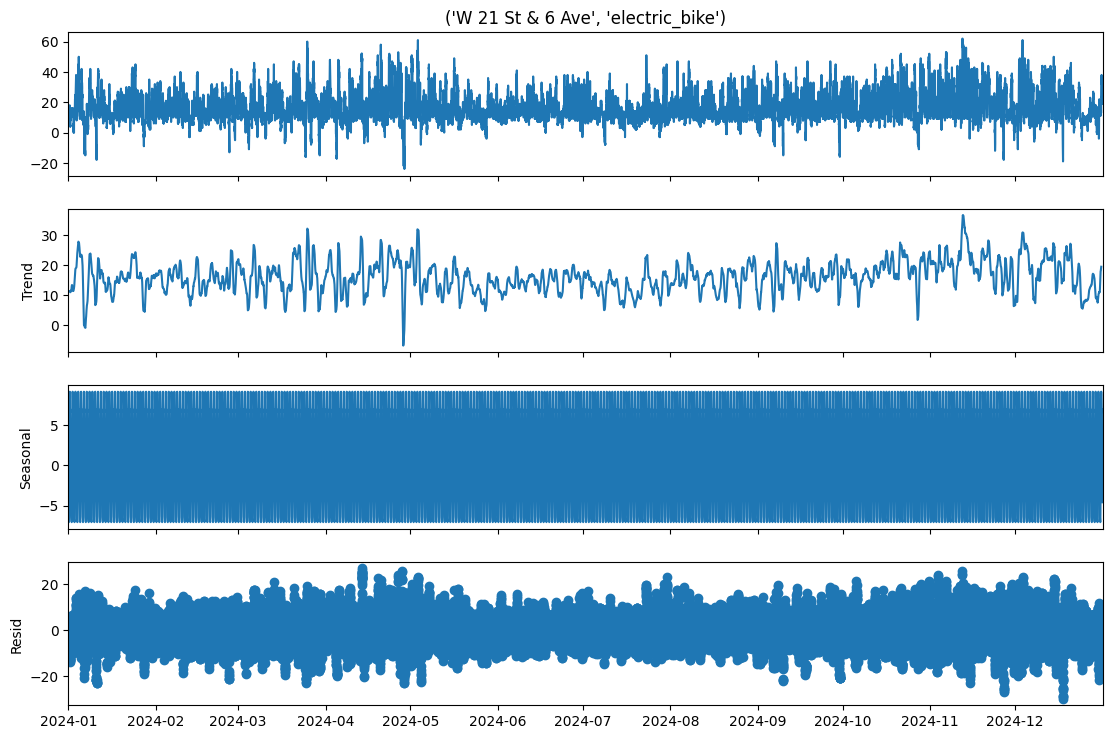

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

target_series = df_ts.loc[:, ('W 21 St & 6 Ave', 'electric_bike')]

decomposition = seasonal_decompose(target_series, model='additive', period=96)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

In [4]:
# 1. Train / Test Split (8:2)
n_obs = len(df_ts)
split_idx = int(n_obs * 0.8)

train_df = df_ts.iloc[:split_idx]
test_df = df_ts.iloc[split_idx:]

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Train data shape: (28108, 6)
Test data shape: (7028, 6)


/Users/hyunwoooh/citi-bike/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


Optimal Lag Order: 16
Starting rolling forecast...
Total Average RMSE (Rolling): 2.5062

RMSE by Station & Type (Rolling):
('University Pl & E 14 St', 'electric_bike'): 2.7211
('W 21 St & 6 Ave', 'classic_bike'): 2.1375
('8 Ave & W 31 St', 'classic_bike'): 1.9487
('8 Ave & W 31 St', 'electric_bike'): 3.2465
('W 21 St & 6 Ave', 'electric_bike'): 2.6755
('University Pl & E 14 St', 'classic_bike'): 2.0535


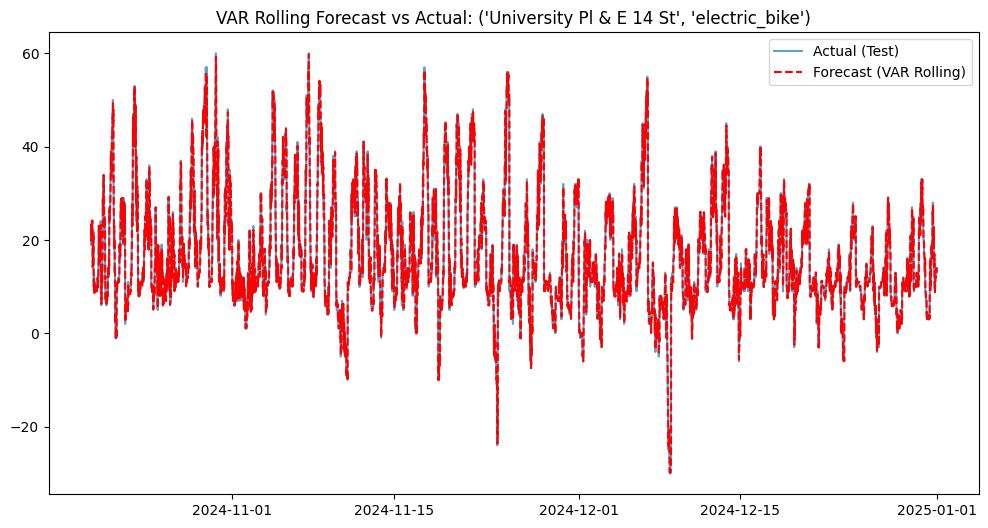

In [ ]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# Differencing
train_diff = train_df.diff().dropna()

with mlflow.start_run():
    # seed_everything(42) # Use if reproducibility is needed

    # --- Train Model ---
    model = VAR(train_diff)

    # Select the best lag order based on AIC
    lags_result = model.select_order(maxlags=16)
    optimal_lag = lags_result.aic
    print(f"Optimal Lag Order: {optimal_lag}")

    # Fit the VAR model
    var_result = model.fit(optimal_lag)
    
    mlflow.log_metric("aic", var_result.aic)
    mlflow.log_metric("bic", var_result.bic)

    # --- Rolling Forecast (One-step-ahead) ---
    lag_order = var_result.k_ar
    
    # Initialize the history with the last part of the training data
    # Converted to a list for easier appending of new observations
    history_diff = train_diff.values[-lag_order:].tolist()
    
    forecast_predictions = []
    
    # Iterate through each step in the test set
    for i in range(len(test_df)):
        
        # 1. Predict the next step (1 step ahead) based on current history
        # The forecast method expects a 2D array, so we reshape the input
        fc_input = np.array(history_diff[-lag_order:]) 
        fc_diff = var_result.forecast(y=fc_input, steps=1) # shape: (1, n_features)
        
        # 2. Invert to Original Scale (Reconstruction)
        # Predicted_Price(t) = Actual_Price(t-1) + Predicted_Diff(t)
        
        if i == 0:
            # For the first prediction, use the last actual value from Train set
            last_actual_stock = train_df.iloc[-1] 
        else:
            # For subsequent predictions, use the previous actual value from Test set
            last_actual_stock = test_df.iloc[i-1] 
        
        # Calculate the absolute predicted price
        pred_stock = last_actual_stock + fc_diff[0]
        forecast_predictions.append(pred_stock)

        # 3. Update History (Crucial for Rolling Forecast)
        # We must append the *Actual Observed Diff*, NOT the predicted diff to ensure the model uses ground truth for the next prediction.
        
        if i == 0:
            # First diff calculation: Test[0] - Train[-1]
            actual_diff = test_df.iloc[i] - train_df.iloc[-1]
        else:
            # Subsequent diffs: Test[i] - Test[i-1]
            actual_diff = test_df.iloc[i] - test_df.iloc[i-1]
            
        # Update the history buffer
        history_diff.append(actual_diff.values)

    # Convert results to DataFrame
    forecast_stock_df = pd.DataFrame(forecast_predictions, index=test_df.index, columns=test_df.columns)

    # --- Evaluation ---
    # Overall RMSE Calculation
    total_rmse = np.sqrt(mean_squared_error(test_df, forecast_stock_df))
    print(f"Total Average RMSE (Rolling): {total_rmse:.4f}\n")
    mlflow.log_metric("test_rmse", total_rmse)

    # RMSE per Station
    print("RMSE by Station & Type (Rolling):")
    for col in test_df.columns:
        col_rmse = np.sqrt(mean_squared_error(test_df[col], forecast_stock_df[col]))
        print(f"{col}: {col_rmse:.4f}")

    # --- Visualization ---
    target_col = test_df.columns[0]
    
    plt.figure(figsize=(12, 6))
    
    # Plot Actual vs Forecast
    plt.plot(test_df.index, test_df[target_col], label='Actual (Test)', alpha=0.7)
    plt.plot(forecast_stock_df.index, forecast_stock_df[target_col], label='Forecast (VAR Rolling)', color='red', linestyle='--')
    
    plt.title(f"VAR Rolling Forecast vs Actual: {target_col}")
    plt.legend()
    plt.show()


In [26]:
var_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 23, Dec, 2025
Time:                     10:33:08
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    11.1536
Nobs:                     28091.0    HQIC:                   11.0378
Log likelihood:          -392834.    FPE:                    58855.6
AIC:                      10.9828    Det(Omega_mle):         57650.8
--------------------------------------------------------------------
Results for equation University Pl & E 14 St_electric_bike
                                               coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------------
const                                             0.000202         0.014447            0.014           0.989
L1.University Pl & E 14 S

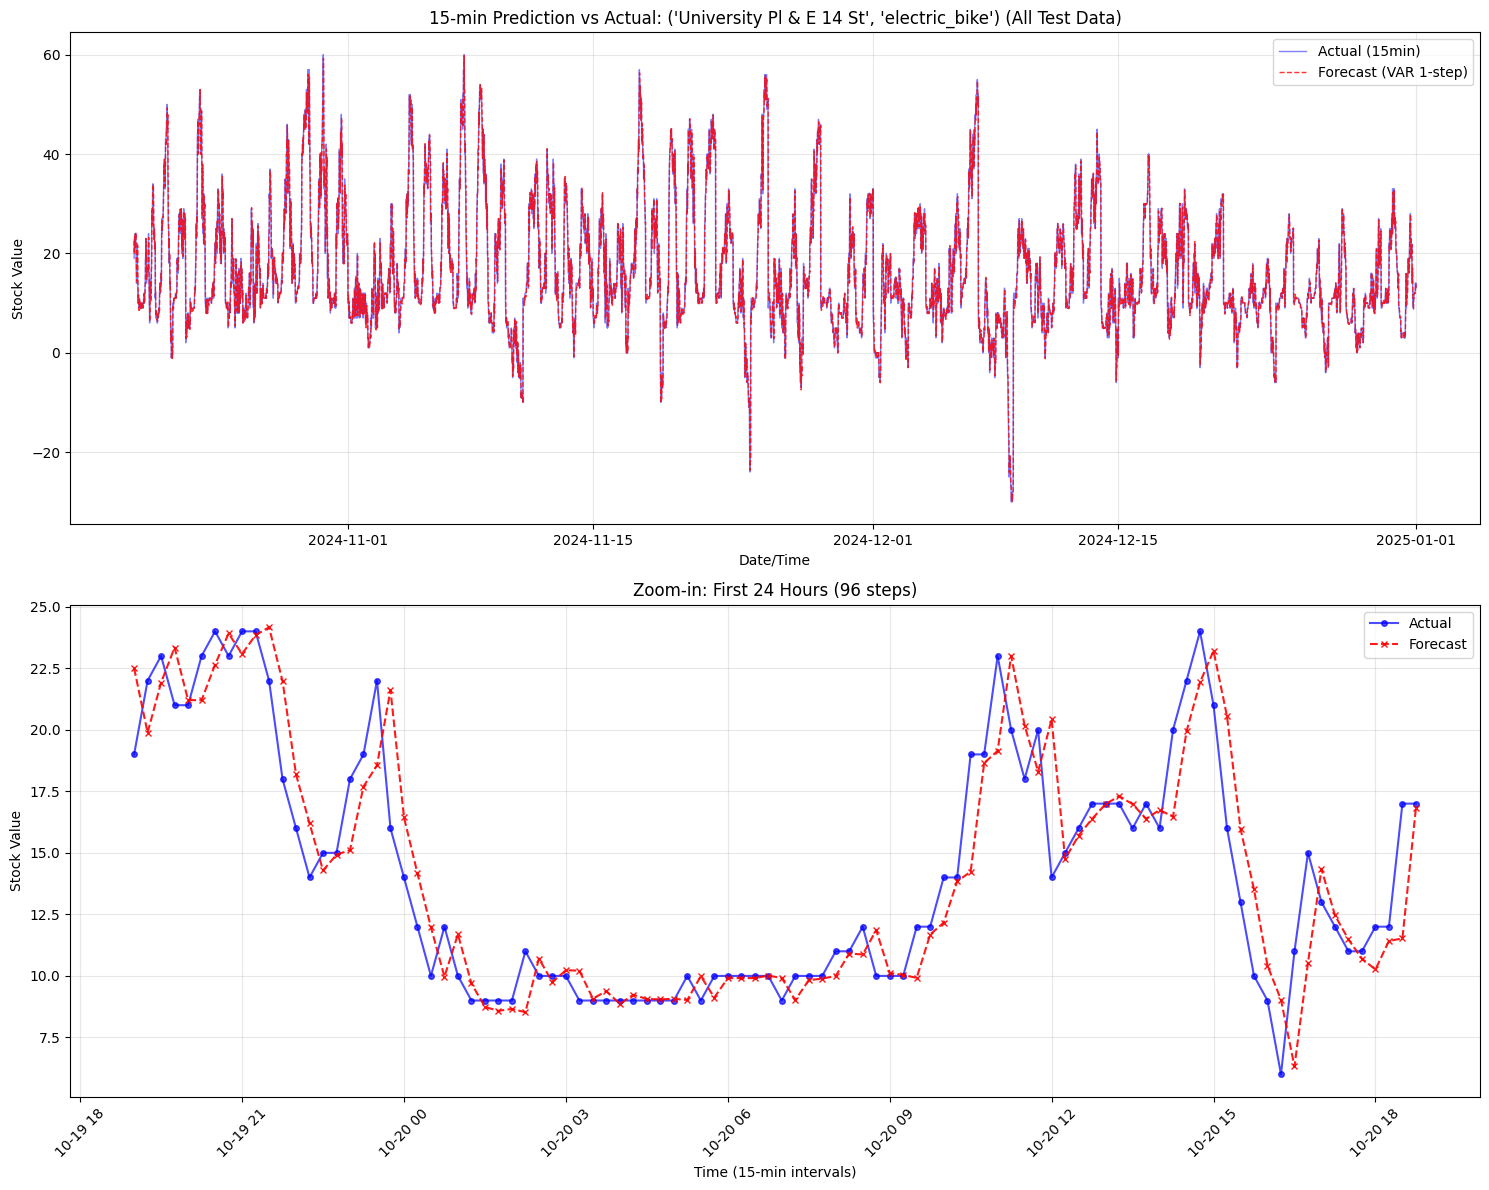

In [27]:
import matplotlib.pyplot as plt


target_col = test_df.columns[0] 

plt.figure(figsize=(15, 12))

# Full test set
plt.subplot(2, 1, 1)
plt.plot(test_df.index, test_df[target_col], label='Actual (15min)', color='blue', alpha=0.5, linewidth=1)
plt.plot(forecast_stock_df.index, forecast_stock_df[target_col], label='Forecast (VAR 1-step)', color='red', linestyle='--', alpha=0.8, linewidth=1)
plt.title(f"15-min Prediction vs Actual: {target_col} (All Test Data)")
plt.xlabel("Date/Time")
plt.ylabel("Stock Value")
plt.legend()
plt.grid(True, alpha=0.3)

# One day
zoom_steps = 96  
if len(test_df) > zoom_steps:
    zoom_actual = test_df[target_col].iloc[:zoom_steps]
    zoom_forecast = forecast_stock_df[target_col].iloc[:zoom_steps]
    
    plt.subplot(2, 1, 2)
    plt.plot(zoom_actual.index, zoom_actual, label='Actual', marker='o', markersize=4, color='blue', alpha=0.7)
    plt.plot(zoom_forecast.index, zoom_forecast, label='Forecast', marker='x', markersize=4, color='red', linestyle='--', alpha=0.9)
    
    plt.title(f"Zoom-in: First 24 Hours ({zoom_steps} steps)")
    plt.xlabel("Time (15-min intervals)")
    plt.ylabel("Stock Value")
    plt.xticks(rotation=45) 
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
# Naive Forecast: shift by 1.
naive_forecast = test_df.shift(1).dropna()
actual_trimmed = test_df.iloc[1:]

naive_rmse = np.sqrt(mean_squared_error(actual_trimmed, naive_forecast))
print(f"Naive Model RMSE: {naive_rmse:.4f}")
print(f"My VAR Model RMSE: {total_rmse:.4f}")

Naive Model RMSE: 2.5293
My VAR Model RMSE: 2.5062


It says that the performance is almost similar to the naive forcast: use the previous result.

## XGBoost

In [8]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform, loguniform

features = [col for col in df.columns if col!='target_next_stock']

X = df[features]
y = df['target_next_stock']

split_idx = int(len(X)*0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [ ]:
mlflow.xgboost.autolog()

seed_everything(42)

with mlflow.start_run():

    model = xgb.XGBRegressor(random_state=42, enable_categorical=True, n_estimators=30, max_depth=20, learning_rate=1e-1)

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    print(f"XGBoost RMSE: {rmse:.4f}")

    mlflow.log_metric("test_rmse", rmse)

    mlflow.save

mlflow.xgboost.autolog(disable=True)

Global Seed set to 42
[0]	validation_0-rmse:11.69808
[1]	validation_0-rmse:10.58364
[2]	validation_0-rmse:9.58489
[3]	validation_0-rmse:8.69700
[4]	validation_0-rmse:7.90593
[5]	validation_0-rmse:7.20152
[6]	validation_0-rmse:6.57846
[7]	validation_0-rmse:6.02669
[8]	validation_0-rmse:5.54662
[9]	validation_0-rmse:5.12014
[10]	validation_0-rmse:4.75884
[11]	validation_0-rmse:4.43849
[12]	validation_0-rmse:4.15391
[13]	validation_0-rmse:3.91102
[14]	validation_0-rmse:3.70840
[15]	validation_0-rmse:3.53394
[16]	validation_0-rmse:3.38933
[17]	validation_0-rmse:3.26370
[18]	validation_0-rmse:3.15155
[19]	validation_0-rmse:3.05766
[20]	validation_0-rmse:2.97549
[21]	validation_0-rmse:2.90565
[22]	validation_0-rmse:2.84514
[23]	validation_0-rmse:2.79504
[24]	validation_0-rmse:2.75203
[25]	validation_0-rmse:2.71432
[26]	validation_0-rmse:2.68229
[27]	validation_0-rmse:2.65422
[28]	validation_0-rmse:2.63136
[29]	validation_0-rmse:2.61080


2025/12/21 22:32:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/hyunwoooh/citi-bike/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/12/21 22:32:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/21 22:32:59 WARNING mlfl

XGBoost RMSE: 2.6108


In [5]:
df2025 = pd.read_csv("../data/2025_timeseries.csv", index_col=0, header=[0, 1], parse_dates=True)
df2025.head()

station             University Pl & E 14 St 8 Ave & W 31 St  \
rideable_type                  classic_bike    classic_bike   
2025-01-01 00:00:00                      10               9   
2025-01-01 00:15:00                      10               9   
2025-01-01 00:30:00                      10               8   
2025-01-01 00:45:00                      10               8   
2025-01-01 01:00:00                      10               9   

station             University Pl & E 14 St 8 Ave & W 31 St W 21 St & 6 Ave  \
rideable_type                 electric_bike   electric_bike   electric_bike   
2025-01-01 00:00:00                       8              10              10   
2025-01-01 00:15:00                       8              11              10   
2025-01-01 00:30:00                       6              13               9   
2025-01-01 00:45:00                       6              13               6   
2025-01-01 01:00:00                       6              11               6   

station                           
rideable_type       classic_bike  
2025-01-01 00:00:00           10  
2025-01-01 00:15:00           10  
2025-01-01 00:30:00           10  
2025-01-01 00:45:00           10  
2025-01-01 01:00:00            8

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192384 entries, 0 to 192383
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   time           192384 non-null  datetime64[ns]
 1   station        192384 non-null  object        
 2   rideable_type  192384 non-null  object        
 3   stock          192384 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 5.9+ MB
None


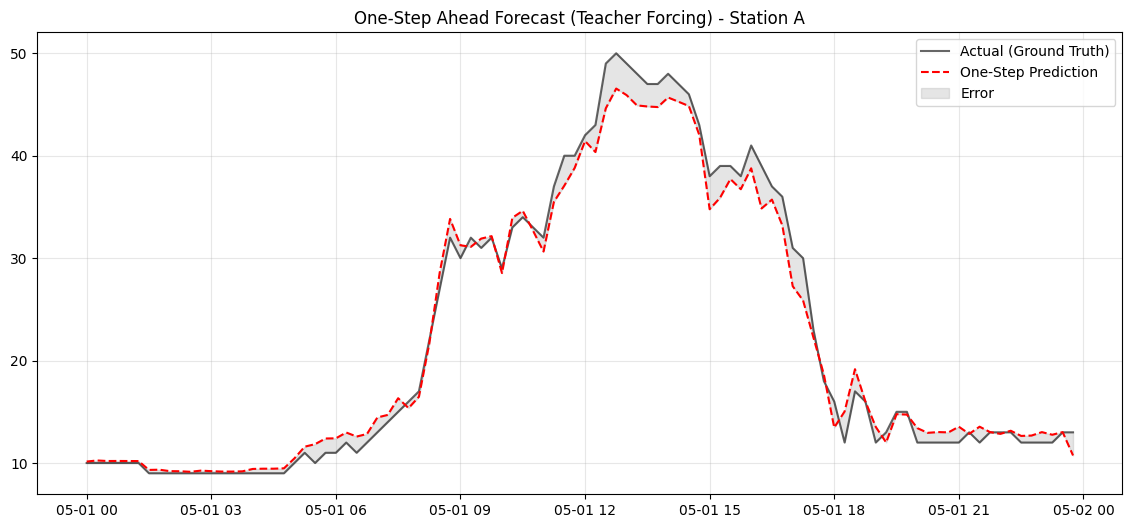

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def predict_one_step_ahead(
    model, 
    df_all,          # DataFrame containing the new information
    station_name, 
    rideable_type, 
    target_date
):
    """
    Predicts using all inputs (including lags) as 'Actual Data'.
    Processes everything at once using Pandas operations without for-loops.
    """
   # -------------------------------------------------------
    # 1. Data Extraction (Station & Type & Date)
    # -------------------------------------------------------
    # Extract data for the specific station and bike type from df_all.
    
    # Define search range: We need data slightly before the target_date to calculate lags.
    start_search = pd.to_datetime(target_date) - pd.Timedelta(hours=2) # 2 hours of buffer
    end_search = pd.to_datetime(target_date) + pd.Timedelta(hours=24)
    
    # Reshape data: Stack MultiIndex and reset to access columns easily
    df_all = df_all.stack(level=[0, 1], future_stack=True).reset_index()
    df_all.columns = ['time', 'station', 'rideable_type', 'stock']

    print(df_all.info())
    
    # Filter for the specific station, bike type, and time window
    mask = (
        (df_all['station'] == station_name) & 
        (df_all['rideable_type'] == rideable_type) &
        (df_all['time'] >= start_search) & 
        (df_all['time'] <= end_search)
    )
    data = df_all.loc[mask].copy()
    

    # -------------------------------------------------------
    # 2. Feature Engineering (Based on Actual Data)
    # -------------------------------------------------------
    # All features created here utilize ground-truth 'Actual Data'.
    
    # A. Lag Features: Create shifts based on the actual 'stock' column
    data['lag_15m_stock'] = data['stock'].shift(1) # 1 row back (15-min interval)
    data['lag_30m_stock'] = data['stock'].shift(2)
    data['lag_45m_stock'] = data['stock'].shift(3)
    data['lag_60m_stock'] = data['stock'].shift(4)
    
    # B. Time-based Features
    data['hour'] = data['time'].dt.hour + data['time'].dt.minute / 60.0
    data['dayofweek'] = data['time'].dt.dayofweek
    data['is_rush_hour'] = data['hour'].apply(
        lambda h: 1 if (8 <= h < 10) or (17 <= h < 19) else 0
    )
    
    # C. Date Numerical Normalization (Scaling date to a 0-1 range)
    start_ts = pd.to_datetime('2024-01-01').value
    end_ts = pd.to_datetime('2025-01-01').value
    data['date'] = (data['time'].dt.normalize().astype(np.int64) - start_ts) / (end_ts - start_ts)

    # -------------------------------------------------------
    # 3. Filter for Target Date
    # -------------------------------------------------------
    target_mask = (data['time'] >= pd.to_datetime(target_date + " 00:00:00")) & \
                  (data['time'] <= pd.to_datetime(target_date + " 23:45:00"))
    
    inference_df = data.loc[target_mask].copy()
    
    # -------------------------------------------------------
    # 4. Inference / Prediction
    # -------------------------------------------------------
    # Define feature order (Must match the order used during model training)
    features = [
        'station', 'rideable_type', 'stock', 
        'hour', 'dayofweek', 'is_rush_hour',
        'lag_15m_stock', 'lag_30m_stock', 'lag_45m_stock', 'lag_60m_stock',
        'date'
    ]
    
    # Convert categorical variables
    inference_df['station'] = inference_df['station'].astype('category')
    inference_df['rideable_type'] = inference_df['rideable_type'].astype('category')
    
    # Batch Prediction
    # Note: This follows a "Teacher Forcing" style where all inputs are Ground Truth.
    inference_df['predicted_stock'] = model.predict(inference_df[features])
    
    # -------------------------------------------------------
    # 5. Result Formatting
    # -------------------------------------------------------
    result = inference_df[['stock', 'predicted_stock']].rename(columns={'stock': 'actual_stock'})
    result['error'] = result['actual_stock'] - result['predicted_stock']
    
    # Re-generate clean time index for the result
    result['time'] = pd.date_range(start=target_date + " 00:00:00", end= target_date + " 23:45:01", freq='15min', inclusive='left')

    result = result.set_index('time')
    
    return result

# -------------------------------------------------------
# Execution and Visualization
# -------------------------------------------------------
# Assumption: 'df2025' is the source DataFrame containing 'station', 'rideable_type', and 'stock'.

df_result = predict_one_step_ahead(
    model=model,
    df_all=df2025,  
    station_name=top3_stations[0],
    rideable_type='classic_bike',
    target_date='2025-05-01'
)

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(df_result.index, df_result['actual_stock'], label='Actual (Ground Truth)', color='black', alpha=0.6)
plt.plot(df_result.index, df_result['predicted_stock'], label='One-Step Prediction', color='red', linestyle='--')

# Highlight Error Area
plt.fill_between(df_result.index, df_result['actual_stock'], df_result['predicted_stock'], color='gray', alpha=0.2, label='Error')

plt.title(f"One-Step Ahead Forecast (Teacher Forcing) - Station A")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Global Seed set to 42


2025/12/21 22:37:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/hyunwoooh/citi-bike/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 5 folds for each of 30 candidates, totalling 150 fits


2025/12/21 22:39:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/hyunwoooh/citi-bike/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/12/21 22:39:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environm

best parameters: {'learning_rate': np.float64(0.20894166286818883), 'max_depth': 6, 'n_estimators': 58}


/Users/hyunwoooh/citi-bike/.venv/lib/python3.13/site-packages/mlflow/models/evaluation/deprecated.py:9: FutureWarning: The `mlflow.evaluate` API has been deprecated as of MLflow 3.0.0. Please use these new alternatives:

 - For traditional ML or deep learning models: Use `mlflow.models.evaluate`, which maintains full compatibility with the original `mlflow.evaluate` API.

 - For LLMs or GenAI applications: Use the new `mlflow.genai.evaluate` API, which offers enhanced features specifically designed for evaluating LLMs and GenAI applications.

  warnings.warn(


/Users/hyunwoooh/citi-bike/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/21 22:39:37 WARNING mlflow.models.evaluation.default_evaluator: Computing sklearn model score failed: ValueError("Passing extra keyword arguments to RandomizedSearchCV.score is only supported if enable_metadata_routing

Evaluation metrics: {'example_count': 42158, 'mean_absolute_error': 1.3722699403212575, 'mean_squared_error': 4.320916726115355, 'root_mean_squared_error': 2.0786814874134407, 'sum_on_target': np.float64(624993.0), 'mean_on_target': np.float64(14.825015418188718), 'r2_score': 0.9741967482452136, 'max_error': 27.497551441192627, 'mean_absolute_percentage_error': 62039822723584.07}


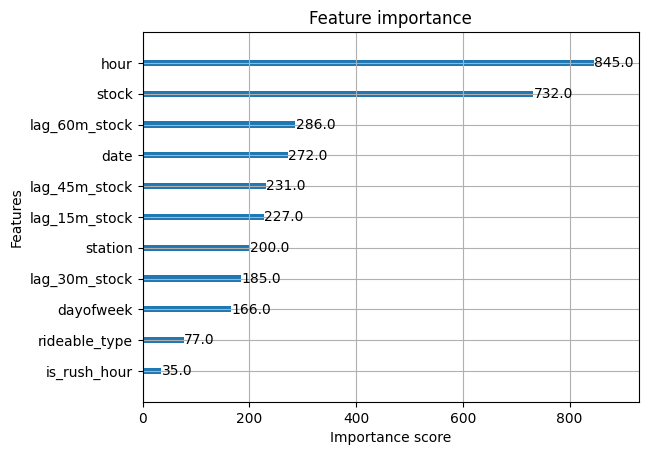

In [12]:
param_dist = {
    'n_estimators': randint(5, 100),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(1e-3, 1)
}

mlflow.sklearn.autolog(max_tuning_runs=5) # 5 is default

with mlflow.start_run() as run:
    seed_everything(42)

    model = xgb.XGBRegressor(random_state=42, enable_categorical=True)

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=30,
        scoring='neg_mean_squared_error',
        cv=5,
        random_state=42,
        n_jobs=4,
        verbose=1
    )

    random_search.fit(X_train, y_train)

    model_xgb = random_search.best_estimator_

    print(f"best parameters: {random_search.best_params_}")

    eval_data = X_test.copy()
    eval_data["target"] = y_test
    model_uri = f"runs:/{run.info.run_id}/model"

    result = mlflow.evaluate(
        model=model_uri,
        data=eval_data,
        targets="target",
        model_type="regressor",
        evaluators=["default"],
        evaluator_config={
            "default": {
                "log_model_explainability": False
            }
        }
    )

    print(f"Evaluation metrics: {result.metrics}")

    preds = model_xgb.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    mlflow.log_metric("test_rmse", rmse)

    xgb.plot_importance(model_xgb)

mlflow.sklearn.autolog(disable=True)


## LSTM

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# GPU/MPS(Mac)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210786 entries, 0 to 210785
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   station            210786 non-null  category
 1   rideable_type      210786 non-null  category
 2   stock              210786 non-null  int64   
 3   hour               210786 non-null  float64 
 4   dayofweek          210786 non-null  int64   
 5   is_rush_hour       210786 non-null  int64   
 6   lag_15m_stock      210786 non-null  float64 
 7   lag_30m_stock      210786 non-null  float64 
 8   lag_45m_stock      210786 non-null  float64 
 9   lag_60m_stock      210786 non-null  float64 
 10  target_next_stock  210786 non-null  float64 
 11  date               210786 non-null  float64 
dtypes: category(2), float64(7), int64(3)
memory usage: 16.5 MB


In [14]:
from sklearn.preprocessing import MinMaxScaler

df_onehot = pd.get_dummies(df, columns=['station', 'rideable_type'])

# lag features are not needed for LSTM
features = [col for col in df_onehot if col!='target_next_stock' and col!='time']
target = 'target_next_stock'

X = df_onehot[features].to_numpy()
y = df_onehot[target].to_numpy().reshape(-1, 1)


scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaled_X = scaler_X.fit_transform(X)
scaled_y = scaler_y.fit_transform(y)

# How long will it lookback? (24 hours)
LOOKBACK_WINDOW = 24*4

def create_sequences(X_data, y_data, lookback):
    X_seq, y_seq = [], []
    # Need to leave a space equal to the lookback window before the end of the data
    for i in range(len(X_data) - lookback):
        # Group the data from i up to just before i+lookback into one chunk (the past 24 hours)
        X_seq.append(X_data[i:i+lookback])
        # The target value at the i+lookback time point (the future time point to predict)
        y_seq.append(y_data[i+lookback])
    return np.array(X_seq), np.array(y_seq)

# 3D tensor
X_lstm, y_lstm = create_sequences(scaled_X, scaled_y, LOOKBACK_WINDOW)

X_lstm = X_lstm.astype(np.float32)
y_lstm = y_lstm.astype(np.float32)

# Check the shape
# Result example: (Number of samples, 24 (hours), 8 (number of features))
print(f"LSTM Input Shape: {X_lstm.shape}")
print(f"LSTM Target Shape: {y_lstm.shape}")




split_idx = int(len(X_lstm) * 0.8)

X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

print(f"Train shape: {X_train_lstm.shape}, Test shape: {X_test_lstm.shape}")

seed_everything(42)

# 1. numpy to torch.tensor
# (Samples, TimeSteps, Features)
X_train_tensor = torch.from_numpy(X_train_lstm).to(device)
y_train_tensor = torch.from_numpy(y_train_lstm).to(device)
X_test_tensor = torch.from_numpy(X_test_lstm).to(device)
y_test_tensor = torch.from_numpy(y_test_lstm).to(device)

# 2. DataLoader 
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # Don't shuffle for time series

LSTM Input Shape: (210690, 96, 14)
LSTM Target Shape: (210690, 1)
Train shape: (168552, 96, 14), Test shape: (42138, 96, 14)
Global Seed set to 42


In [15]:
class BikeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(BikeLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM Layer
        # batch_first=True: Sets input dimension to (Batch, Seq, Feature)
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout_prob
        )
        
        # Fully Connected Layer (Output)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (Batch, Seq_Len, Features)
        
        # If h0, c0 are not set, they are automatically initialized to 0
        # out shape: (Batch, Seq_Len, Hidden_Size)
        out, (hn, cn) = self.lstm(x)
        
        # Use only the Hidden State of the last Time Step for a Many-to-One structure
        # out[:, -1, :] : Data from the last time step for all batches
        out = out[:, -1, :] 
        
        # Final prediction
        out = self.fc(out)
        return out
    

# Random seed
seed_everything(42)

# Hyperparameters
input_size = X_train_lstm.shape[2] # Number of features
hidden_size = 64
num_layers = 2 
output_size = 1
dropout_prob = 0.0 

model = BikeLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)
print(model)

Global Seed set to 42
BikeLSTM(
  (lstm): LSTM(14, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [16]:
# Loss & Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 10
train_losses = []

with mlflow.start_run():
    mlflow.log_params({"hidden_size": hidden_size, "num_layers": num_layers, "dropout_prob": dropout_prob})

    model.train() # train mode

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        for inputs, targets in train_loader:
            # 1. Reset Gradients
            optimizer.zero_grad()
            
            # 2. Forward Pass
            outputs = model(inputs)
            
            # 3. Loss
            loss = criterion(outputs, targets)
            
            # 4. Backward Pass & Optimize
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * inputs.size(0)
        
        # Loss
        epoch_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        if (epoch+1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")
            mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)

    from sklearn.metrics import mean_squared_error

    model.eval() # Evaluation mode
    model.to('cpu')
    with torch.no_grad():
        # Predict
        predictions = model(X_test_tensor.cpu())
        
        # GPU to CPU to numpy
        predictions = predictions.cpu().numpy()
        y_test_actual = y_test_tensor.cpu().numpy()

    # Inverse Transform
    predicted_stock = scaler_y.inverse_transform(predictions)
    actual_stock = scaler_y.inverse_transform(y_test_actual)

    # RMSE
    rmse_torch = np.sqrt(mean_squared_error(actual_stock, predicted_stock))
    print(f"LSTM RMSE: {rmse_torch:.4f}")

    mlflow.log_metric("test_rmse", rmse_torch)

    mlflow.pytorch.log_model(model, "model")

    print(f"Run ID: {mlflow.active_run().info.run_id}")

Epoch [5/10], Loss: 0.005598
Epoch [10/10], Loss: 0.005598


2025/12/21 23:04:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


LSTM RMSE: 13.5616


2025/12/21 23:04:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Run ID: 6f0b245f09784defac503c66625cc895


# Best model

In [34]:
import mlflow
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("citi-bike")

metric_name = "metrics.test_rmse"
order_clause = f"{metric_name} ASC"

client= MlflowClient()

experiment = client.get_experiment_by_name("citi-bike")

experiment_id = experiment.experiment_id

runs = client.search_runs(
    experiment_ids = [experiment_id],
    filter_string="",
    order_by=[order_clause],
    max_results=1
)

if runs:
    best_run = runs[0]
    best_run_id = best_run.info.run_id
    best_val = best_run.data.metrics.get("test_rmse", 'N/A')
    print(f"Best Run ID: {best_run_id}, Score: {best_val}")

    model_uri = f"runs:/{best_run_id}/model"
    model_name = "CitiBike_Predictor"

    result = mlflow.register_model(model_uri, model_name)

    print(f"Version: {result.version}")

2025/12/23 11:41:02 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/23 11:41:02 INFO mlflow.store.db.utils: Updating database tables
2025/12/23 11:41:02 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/23 11:41:02 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Best Run ID: b7ee513e84bd42d7b0201018eefcd810, Score: 2.0786814874134407


Successfully registered model 'CitiBike_Predictor'.
2025/12/23 11:41:02 WARNING mlflow.tracking._model_registry.fluent: Run with id b7ee513e84bd42d7b0201018eefcd810 has no artifacts at artifact path 'model', registering model based on models:/m-2875823601e14214b697ed2399cbdcde instead


Version: 1


Created version '1' of model 'CitiBike_Predictor'.


In [39]:
client = MlflowClient()

client.set_registered_model_alias(
    name="CitiBike_Predictor",
    alias="champion",
    version="1"
)

In [51]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")

model_uri = "models:/CitiBike_Predictor@champion"

print(f"Loading model from: {model_uri}")
# Because it uses categorical variables, we directly use the XGBoost model
xgboost_model = mlflow.sklearn.load_model(model_uri)

input_data = X_test.iloc[:10]


predictions = xgboost_model.predict(input_data)

print("Prediction using the best model", predictions)


Loading model from: models:/CitiBike_Predictor@champion
Prediction using the best model [19.727808  21.136723  21.761335  14.891249  -1.8176295 43.285225
 18.479132  20.878845  22.672401  14.136944 ]


In [49]:
input_data = X_test.copy()

predictions = xgboost_model.predict(input_data)

np.sqrt(mean_squared_error(predictions, y_test))

np.float64(2.0786814874134407)

In [55]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
client = MlflowClient()

model_name = "CitiBike_Predictor"
version = 1

client.update_model_version(name=model_name,
                            version=version,
                            description="Best model with XGBoost"
                            )

<ModelVersion: aliases=['champion'], creation_timestamp=1766508062581, current_stage='Production', deployment_job_state=None, description='Best model with XGBoost', last_updated_timestamp=1766510296830, metrics=None, model_id=None, name='CitiBike_Predictor', params=None, run_id='b7ee513e84bd42d7b0201018eefcd810', run_link=None, source='models:/m-2875823601e14214b697ed2399cbdcde', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [ ]:
import sqlite3
import pandas as pd

# Connect to database
con = sqlite3.connect("mlflow.db")

# 2. Check model versions
query = "SELECT name, version, run_id, source FROM model_versions"
df = pd.read_sql_query(query, con)

print(df)

con.close()

                 name  version                            run_id  \
0  CitiBike_Predictor        1  b7ee513e84bd42d7b0201018eefcd810   

                                       source  
0  models:/m-2875823601e14214b697ed2399cbdcde  
